In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np  # Import Numerical Python
from IPython.display import display, HTML  # Import HTML for formatting output

from arc import *  # Import ARC (Alkali Rydberg Calculator)

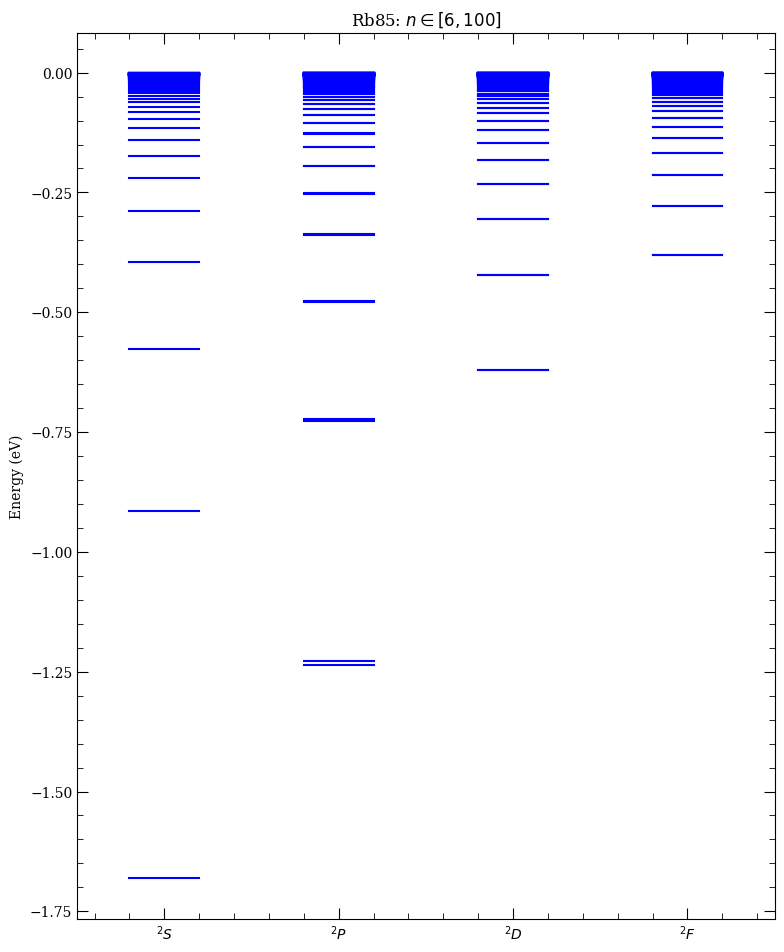

In [2]:


# Load parameters for Caesium
atom = Rubidium()

nmin = 6  # Minimum n
nmax = 100  # Maximum n
lmin = 0  # Minimum l
lmax = 3  # Maxmium l

# Plot Energy Levels of Cesium
levels = LevelPlot(atom)
levels.makeLevels(nmin, nmax, lmin, lmax)
levels.drawLevels()
levels.showPlot()

In [13]:
suitable_transitions = []
for i in range(6, 100):
    for j in range(i+1, 100):
        l1 = 0
        l2 = 0
        j1 = 0.5
        j2 = 0.5

        GHz = atom.getTransitionFrequency(i, l1, j1, j, l2, j2) / 1e9
        if GHz > 1 and GHz < 30:
            suitable_transitions.append([i, j, GHz])

print (len(suitable_transitions))
for transition in suitable_transitions:
    print (transition)


63
[63, 64, 29.91062723209271]
[64, 65, 28.472018166785766]
[65, 66, 27.124208519243226]
[66, 67, 25.860146062432733]
[67, 68, 24.673425784951995]
[68, 69, 23.558221638484863]
[69, 70, 22.509226388896707]
[70, 71, 21.521598504397296]
[71, 72, 20.590915167925502]
[72, 73, 19.71313063061323]
[73, 74, 18.884539232895534]
[74, 75, 18.101742512876843]
[75, 76, 17.361619900646613]
[76, 77, 16.66130256465638]
[77, 78, 15.998150033795664]
[78, 79, 15.369729268120091]
[79, 80, 14.77379589340976]
[79, 81, 28.98207324451811]
[80, 81, 14.208277351108345]
[80, 82, 27.879535097573996]
[81, 82, 13.67125774646565]
[81, 83, 26.832221951208552]
[82, 83, 13.160964204742903]
[82, 84, 25.83671877344099]
[83, 84, 12.675754568698089]
[83, 85, 24.88986085950724]
[84, 85, 12.214106290809148]
[84, 86, 23.98871268208994]
[85, 86, 11.77460639128079]
[85, 87, 23.130548759431623]
[86, 87, 11.355942368150831]
[86, 88, 22.312836327284167]
[87, 88, 10.956893959133337]
[87, 89, 21.53321962558864]
[88, 89, 10.5763256664

In [27]:
import math

def calculate_cavity_dimensions(frequency_ghz: float, mode_p: int = 1):
    """
    Calculates dimensions for a TE10p rectangular microwave cavity.

    This function takes a target frequency and a longitudinal mode number 'p'
    to compute the optimal width (a), height (b), and length (d) for a
    rectangular cavity. Using a higher 'p' (e.g., 3, 5) allows for a
    physically larger cavity at high frequencies, which can be easier to
    fabricate and handle.

    The design heuristics used are:
    - Width 'a' is set to 0.75 * microwave_wavelength for good performance.
    - Height 'b' is set to a / 2 to optimize the Q-factor.

    Args:
        frequency_ghz: The target resonant frequency in Gigahertz (GHz).
        mode_p: The longitudinal mode number (number of half-wavelengths
                along the cavity length). Must be an integer >= 1.

    Returns:
        A dictionary containing the calculated dimensions and hole size,
        or None if the design is not physically possible.
    """
    # --- Input Validation ---
    if not isinstance(mode_p, int) or mode_p < 1:
        print("Error: mode_p must be an integer greater than or equal to 1.")
        return None

    # --- Constants ---
    C = 299792458  # Speed of light in m/s

    # --- Calculations ---
    frequency_hz = frequency_ghz * 1e9  # Convert GHz to Hz
    lambda_mw = C / frequency_hz  # Microwave wavelength in meters

    # 1. Set Cavity Width 'a' and Height 'b' based on heuristics
    # The width 'a' must be greater than lambda_mw / 2 for the TE10p mode to exist.
    # A common design choice is a = 0.75 * lambda_mw.
    a_meters = 0.75 * lambda_mw
    
    # The height 'b' is often chosen as a/2 to optimize Q-factor.
    b_meters = a_meters / 2.0

    # 2. Calculate Required Cavity Length 'd'
    # The formula for the TE10p resonant frequency is:
    # f = (c/2) * sqrt((1/a)^2 + (p/d)^2)
    # We rearrange it to solve for d.
    
    # Term inside the square root must be positive
    term_sq = (2 * frequency_hz / C)**2 - (1 / a_meters)**2
    
    if term_sq <= 0:
        print(f"Error: Frequency {frequency_ghz} GHz is too low for a cavity of this width.")
        print(f"The cutoff frequency for a width of {a_meters*100:.2f} cm is "
              f"{(C / (2 * a_meters))/1e9:.2f} GHz. Try a lower frequency.")
        return None

    # The length 'd' is now proportional to the mode number 'p'
    d_meters = mode_p / math.sqrt(term_sq)

    # 3. Calculate Maximum Hole Size
    # The hole diameter should be < lambda_mw / 10 to prevent field leakage.
    max_hole_diameter_meters = lambda_mw / 10.0

    # --- Format for Output ---
    results = {
        "frequency_ghz": frequency_ghz,
        "mode_p": mode_p,
        "microwave_wavelength_cm": lambda_mw * 100,
        "cavity_width_cm": a_meters * 100,
        "cavity_height_cm": b_meters * 100,
        "cavity_length_cm": d_meters * 100,
        "max_hole_diameter_mm": max_hole_diameter_meters * 1000,
    }

    return results

def print_results(results: dict):
    """Prints the calculated cavity dimensions in a user-friendly format."""
    if results is None:
        return
        
    print(f"--- Rectangular Cavity Design (TE10{results['mode_p']} Mode) ---")
    print(f"Target Frequency:         {results['frequency_ghz']:.4f} GHz")
    print(f"Microwave Wavelength:     {results['microwave_wavelength_cm']:.4f} cm")
    print("\n--- Calculated Cavity Dimensions ---")
    print(f"Width (a):                {results['cavity_width_cm']:.4f} cm")
    print(f"Height (b):               {results['cavity_height_cm']:.4f} cm")
    print(f"Length (d):               {results['cavity_length_cm']:.4f} cm")
    print("\n--- Laser Access Holes ---")
    print(f"Max Recommended Diameter: {results['max_hole_diameter_mm']:.4f} mm")
    print("--------------------------------------------------")


print_results(calculate_cavity_dimensions(13.67125774646565, mode_p=2))

--- Rectangular Cavity Design (TE102 Mode) ---
Target Frequency:         13.6713 GHz
Microwave Wavelength:     2.1929 cm

--- Calculated Cavity Dimensions ---
Width (a):                1.6447 cm
Height (b):               0.8223 cm
Length (d):               2.9420 cm

--- Laser Access Holes ---
Max Recommended Diameter: 2.1929 mm
--------------------------------------------------
